In [315]:
%load_ext autoreload
%autoreload 1
%aimport src
%aimport src.utils
%aimport src.SdmIsmAnalysis
%aimport src.SimpleSynthesis

# display last assigned variable automatically
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

%matplotlib inline
from matplotlib.pyplot import *

from src.utils import mygrid

import seaborn as sns
import polars as pl
import numpy as np
import scipy
from pathlib import Path

from unittest.mock import Mock
import pyperclip
import functools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
rooms = ["HL05W", "HL06W"]

listeners = [
    "0.0X_0.0Y",
    "3.0X_2.0Y",
    "1.75X_-2.0Y",
    "-1.75X_-3.0Y",  # lower right corner in floor plan
    "-1.25X_0.0Y",
]

sources = range(5)

range(0, 5)

In [22]:
main_path = Path("../data/processed/analysis_e10_full_run2")

WindowsPath('../data/processed/analysis_e10_full_run2')

In [32]:
counter = 0
presynth_dfs = []
quality_dfs = []

for room in rooms:
    for from_listener in listeners:
        for from_source in sources:
            from_name = f"{room}_{from_listener}_{from_source}SRC"
            from_path = main_path / from_name
            print(from_path)
            new_df = pl.read_parquet(from_path / "runs.parquet").with_row_index("index").with_columns(room=pl.lit(room), from_listener=pl.lit(from_listener), from_source=pl.lit(from_source))
            presynth_dfs.append(new_df)
            for to_listener in listeners:
                for to_source in sources:
                    save_path = from_path / "extrapolation_quality"
                    to_name = f"{room}_{to_listener}_{to_source}SRC"
                    new_df = pl.read_parquet(save_path / to_name).with_columns(
                        room=pl.lit(room), 
                        from_listener=pl.lit(from_listener), 
                        from_source=pl.lit(from_source), 
                        to_listener=pl.lit(to_listener), 
                        to_source=pl.lit(to_source)
                    ).with_columns(
                        xcorr_inv_add = 1 - pl.col("xcorr"),
                        rmse_lin = 10 ** (pl.col("rmse")/20),
                    ).select(pl.exclude("rmse", "xcorr_inv"))
                    quality_dfs.append(new_df)
                    counter += 1
presynth = pl.concat(presynth_dfs, how="diagonal")
quality = pl.concat(quality_dfs, how="diagonal")
print(counter)

..\data\processed\analysis_e10_full_run2\HL05W_0.0X_0.0Y_0SRC
..\data\processed\analysis_e10_full_run2\HL05W_0.0X_0.0Y_1SRC
..\data\processed\analysis_e10_full_run2\HL05W_0.0X_0.0Y_2SRC
..\data\processed\analysis_e10_full_run2\HL05W_0.0X_0.0Y_3SRC
..\data\processed\analysis_e10_full_run2\HL05W_0.0X_0.0Y_4SRC
..\data\processed\analysis_e10_full_run2\HL05W_3.0X_2.0Y_0SRC
..\data\processed\analysis_e10_full_run2\HL05W_3.0X_2.0Y_1SRC
..\data\processed\analysis_e10_full_run2\HL05W_3.0X_2.0Y_2SRC
..\data\processed\analysis_e10_full_run2\HL05W_3.0X_2.0Y_3SRC
..\data\processed\analysis_e10_full_run2\HL05W_3.0X_2.0Y_4SRC
..\data\processed\analysis_e10_full_run2\HL05W_1.75X_-2.0Y_0SRC
..\data\processed\analysis_e10_full_run2\HL05W_1.75X_-2.0Y_1SRC
..\data\processed\analysis_e10_full_run2\HL05W_1.75X_-2.0Y_2SRC
..\data\processed\analysis_e10_full_run2\HL05W_1.75X_-2.0Y_3SRC
..\data\processed\analysis_e10_full_run2\HL05W_1.75X_-2.0Y_4SRC
..\data\processed\analysis_e10_full_run2\HL05W_-1.75X_-3.0Y_

In [24]:
presynth

index,src,start,stop,m0,m1,m2,imsrc_sample,highest_peak_idx_in_peaks,doa_std,doa_nn,distance_boost,order,m0_hf,m1_hf,m2_hf,peak_prominence,doa_stability_1deg,doa_stability_5deg,relative_imsrc_time,directivity_boost,filter_energy,room,from_listener,from_source
u32,i64,i64,i64,f64,f64,f64,i32,i64,f64,f64,f64,i32,f64,f64,f64,f64,i64,i64,f64,f64,f64,str,str,i32
0,0,0,1090,0.071105,23.424951,5.224281,1000,13,2.031673,0.775229,10.265093,0,0.032842,9.159371,3.614078,15.191556,10,54,0.917431,25.197006,0.0,"""HL05W""","""0.0X_0.0Y""",0
1,1,1090,1182,0.071312,-10.139235,5.826576,1152,17,0.766935,0.913043,12.760934,1,0.032819,-13.588524,5.168121,13.075156,6,29,0.673913,24.376448,2.788308,"""HL05W""","""0.0X_0.0Y""",0
2,2,1475,1543,0.092744,-6.631503,2.352815,1512,24,1.089485,0.882353,16.802765,1,0.081459,-7.582317,1.930367,84.343232,33,57,0.544118,4.117089,-1.899535,"""HL05W""","""0.0X_0.0Y""",0
3,6,1182,1237,0.022534,-3.983457,4.521039,1209,19,1.165715,0.909091,13.541279,1,0.013935,-4.481781,4.737973,1.64649,3,3,0.490909,24.464293,-3.250034,"""HL05W""","""0.0X_0.0Y""",0
4,8,1543,1615,0.088686,-9.524603,4.57512,1593,26,0.621013,0.930556,17.493347,2,0.075608,-10.54029,4.108845,13.632943,36,52,0.694444,7.02111,-0.702202,"""HL05W""","""0.0X_0.0Y""",0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
13,183,1702,1772,0.069725,-4.717887,6.431363,1738,32,5.303597,0.728571,17.087682,4,0.041144,-5.768154,5.060668,6.445522,8,16,0.514286,5.248962,-6.045544,"""HL06W""","""-1.25X_0.0Y""",4
14,184,1793,1836,0.020998,152.238806,4.561326,1663,35,7.0573,0.27907,16.40967,4,0.019172,152.049747,4.669508,2.499006,2,2,-3.023256,4.071061,-11.782945,"""HL06W""","""-1.25X_0.0Y""",4
15,215,2010,2054,0.025709,-15.8773,4.183936,2045,41,5.59564,0.272727,19.411317,4,0.023616,-16.04473,4.0855,9.163085,2,3,0.795455,24.309095,10.476384,"""HL06W""","""-1.25X_0.0Y""",4


In [25]:
quality

lag,lag_std,lag_rms,xcorr,xcorr_std,level_delta,level_rms,misdistributed_energy,t30_rel_delta,t30_rel_rms,c20_delta,c20_rms,iacc_delta,iacc_rms,lag_iacc_delta,lag_iacc_rms,ild_delta,ild_rms,spectral_difference,dropped,room,from_listener,from_source,to_listener,to_source,xcorr_inv_add,rmse_lin
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,i32,str,i32,f64,f64
0.0,0.5,0.5,0.685015,0.066863,0.143752,0.444134,0.027252,-0.010375,0.011302,0.172831,0.834144,0.00278,0.020349,-2.333333,9.617692,0.113591,0.678202,0.188265,null,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.314985,0.847395
0.041667,0.538452,0.540062,0.669059,0.070174,0.029059,0.398049,0.03707,-0.009724,0.01062,-0.258614,1.02317,-0.007633,0.021892,-0.5,11.895377,0.119067,0.608876,0.251109,0,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.330941,0.86276
0.0,0.5,0.5,0.664584,0.06993,-0.029632,0.403611,0.036893,-0.009336,0.010241,-0.609136,1.344889,-0.018629,0.027452,-0.75,11.905881,0.120967,0.614706,0.297969,1,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.335416,0.864161
0.0,0.408248,0.408248,0.673669,0.058177,-0.504449,0.742119,0.04765,-0.006027,0.007669,-1.267474,1.353219,0.028079,0.039645,-0.583333,10.234745,0.001088,0.943257,0.200001,2,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.326331,0.802749
0.0,0.5,0.5,0.683192,0.067177,0.131026,0.436326,0.027709,-0.010272,0.01119,0.124264,0.842877,0.003249,0.020154,-1.25,9.096703,0.114144,0.667367,0.189688,3,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.316808,0.84903
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.0,0.0,0.0,0.819027,0.076034,-0.465129,0.56256,0.025812,0.009379,0.011647,0.322351,0.670006,-0.050061,0.05954,-1.833333,7.593857,-0.032233,0.380467,0.269548,13,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,0.180973,0.590999
0.0,0.0,0.0,0.826898,0.068011,-0.352885,0.487518,0.020677,0.007298,0.009559,0.598836,0.988601,-0.05534,0.066409,-1.75,7.555351,-0.013144,0.41587,0.264439,14,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,0.173102,0.581981
0.0,0.0,0.0,0.82499,0.069463,-0.321181,0.480915,0.020063,0.006832,0.009377,0.550239,0.931345,-0.05384,0.065644,-1.75,7.555351,-0.020014,0.463431,0.260238,15,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,0.17501,0.586611


In [26]:
quality.filter(pl.col("dropped").is_null()).count()

lag,lag_std,lag_rms,xcorr,xcorr_std,level_delta,level_rms,misdistributed_energy,t30_rel_delta,t30_rel_rms,c20_delta,c20_rms,iacc_delta,iacc_rms,lag_iacc_delta,lag_iacc_rms,ild_delta,ild_rms,spectral_difference,dropped,room,from_listener,from_source,to_listener,to_source,xcorr_inv_add,rmse_lin
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
1250,1250,1250,1250,1250,1250,1250,1250,1057,1057,1057,1057,1250,1250,1250,1250,1250,1250,1250,0,1250,1250,1250,1250,1250,1250,1250


Now change from absolute quality to quality difference when dropping a reflection:

In [27]:
key_columns = ["room", "from_listener", "from_source", "to_listener", "to_source"]

['room', 'from_listener', 'from_source', 'to_listener', 'to_source']

In [28]:
non_key_columns = list(set(quality.columns) - set(key_columns))

['c20_rms',
 'level_rms',
 'dropped',
 'misdistributed_energy',
 'ild_rms',
 'iacc_rms',
 'ild_delta',
 'lag_iacc_delta',
 't30_rel_rms',
 'xcorr_std',
 'lag_iacc_rms',
 'c20_delta',
 'xcorr_inv_add',
 'iacc_delta',
 'lag_rms',
 'spectral_difference',
 'rmse_lin',
 'lag',
 'lag_std',
 'level_delta',
 't30_rel_delta',
 'xcorr']

In [29]:
non_key_columns_no_dropped = list(set(quality.columns) - set(key_columns) - set(["dropped"]))

['c20_rms',
 'misdistributed_energy',
 'ild_rms',
 'iacc_rms',
 'ild_delta',
 'level_delta',
 'lag_iacc_delta',
 't30_rel_rms',
 'xcorr_std',
 'lag_iacc_rms',
 'c20_delta',
 'xcorr_inv_add',
 'iacc_delta',
 'lag_rms',
 'spectral_difference',
 'rmse_lin',
 'lag',
 'lag_std',
 'level_rms',
 't30_rel_delta',
 'xcorr']

In [30]:
non_key_columns_no_dropped_no_reverb = list(set(quality.columns) - set(key_columns) - set(["dropped", "t30_rel_delta", 't30_rel_rms', 'c20_delta', 'c20_rms']))

['lag_iacc_rms',
 'xcorr_inv_add',
 'lag_std',
 'misdistributed_energy',
 'ild_rms',
 'iacc_delta',
 'lag_rms',
 'spectral_difference',
 'iacc_rms',
 'ild_delta',
 'level_delta',
 'rmse_lin',
 'lag_iacc_delta',
 'lag',
 'level_rms',
 'xcorr_std',
 'xcorr']

In [33]:
# subtract the quality metrics without dropout from all values, remove the non-dropout value
delta_quality_dfs = []
for i in range(len(quality_dfs)):
    if "t30_rel_delta" in quality_dfs[i].columns:
        cols = non_key_columns_no_dropped
    else:
        cols = non_key_columns_no_dropped_no_reverb
    delta_quality_dfs.append(
        quality_dfs[i].filter(pl.col("dropped").is_not_null()).select(
            pl.struct(cols).alias("struct") - quality_dfs[i].filter(pl.col("dropped").is_null()).select(cols).to_struct(),
            pl.col("dropped", *key_columns),
        ).unnest("struct").with_columns(xcorr_inv = -pl.col("xcorr"))
    )
delta_quality = pl.concat(delta_quality_dfs, how="diagonal")

c20_rms,misdistributed_energy,ild_rms,iacc_rms,ild_delta,level_delta,lag_iacc_delta,t30_rel_rms,xcorr_std,lag_iacc_rms,c20_delta,xcorr_inv_add,iacc_delta,lag_rms,spectral_difference,rmse_lin,lag,lag_std,level_rms,t30_rel_delta,xcorr,dropped,room,from_listener,from_source,to_listener,to_source,xcorr_inv
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,i32,str,i32,f64
0.189026,0.009818,-0.069326,0.001544,0.005475,-0.114693,1.833333,-0.000681,0.00331,2.277685,-0.431446,0.015956,-0.010413,0.040062,0.062844,0.015365,0.041667,0.038452,-0.046085,0.000651,-0.015956,0,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.015956
0.510745,0.009641,-0.063496,0.007104,0.007376,-0.173383,1.583333,-0.001061,0.003067,2.288189,-0.781968,0.020431,-0.021409,0.0,0.109704,0.016766,0.0,0.0,-0.040523,0.001039,-0.020431,1,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.020431
0.519075,0.020398,0.265055,0.019296,-0.112503,-0.648201,1.75,-0.003633,-0.008686,0.617053,-1.440305,0.011345,0.025299,-0.091752,0.011736,-0.044646,0.0,-0.091752,0.297984,0.004348,-0.011345,2,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.011345
0.008733,0.000458,-0.010835,-0.000195,0.000553,-0.012726,1.083333,-0.000112,0.000314,-0.520989,-0.048568,0.001823,0.000468,0.0,0.001423,0.001635,0.0,0.0,-0.007808,0.000102,-0.001823,3,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.001823
0.263707,0.021157,-0.209622,0.012876,-0.019235,-0.43379,2.0,-0.002929,0.005082,1.268078,-1.095852,0.009926,0.014951,0.0,0.025677,-0.012679,0.083333,-0.006993,-0.020251,0.002779,-0.009926,4,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.009926
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.252701,0.005881,-0.08415,-0.006662,-0.013472,-0.153566,-0.083333,0.002295,0.006415,0.038506,-0.211714,0.005785,0.004373,0.0,0.00655,0.003801,0.0,0.0,0.088406,0.002673,-0.005785,13,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,0.005785
0.065895,0.000746,-0.048747,0.000208,0.005617,-0.041322,0.0,0.000207,-0.001608,0.0,0.064771,-0.002087,-0.000906,0.0,0.001442,-0.005217,0.0,0.0,0.013364,0.000592,0.002087,14,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,-0.002087
0.008639,0.000132,-0.001185,-0.000558,-0.001253,-0.009618,0.0,0.000025,-0.000155,0.0,0.016174,-0.000178,0.000594,0.0,-0.002759,-0.000586,0.0,0.0,0.006761,0.000126,0.000178,15,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,-0.000178


In [34]:
delta_quality.shape

(19380, 28)

In [35]:
delta_joined = delta_quality.with_columns(
    index = pl.col("dropped").cast(pl.UInt32)
).join(
    presynth,
     ["room", "from_listener", "from_source", "index"],
    #validate="m:1",
).with_columns(
    length = pl.col("stop") - pl.col("start")
)

c20_rms,misdistributed_energy,ild_rms,iacc_rms,ild_delta,level_delta,lag_iacc_delta,t30_rel_rms,xcorr_std,lag_iacc_rms,c20_delta,xcorr_inv_add,iacc_delta,lag_rms,spectral_difference,rmse_lin,lag,lag_std,level_rms,t30_rel_delta,xcorr,dropped,room,from_listener,from_source,to_listener,to_source,xcorr_inv,index,src,start,stop,m0,m1,m2,imsrc_sample,highest_peak_idx_in_peaks,doa_std,doa_nn,distance_boost,order,m0_hf,m1_hf,m2_hf,peak_prominence,doa_stability_1deg,doa_stability_5deg,relative_imsrc_time,directivity_boost,filter_energy,length
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,i32,str,i32,f64,u32,i64,i64,i64,f64,f64,f64,i32,i64,f64,f64,f64,i32,f64,f64,f64,f64,i64,i64,f64,f64,f64,i64
0.189026,0.009818,-0.069326,0.001544,0.005475,-0.114693,1.833333,-0.000681,0.00331,2.277685,-0.431446,0.015956,-0.010413,0.040062,0.062844,0.015365,0.041667,0.038452,-0.046085,0.000651,-0.015956,0,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.015956,0,0,0,1090,0.071105,23.424951,5.224281,1000,13,2.031673,0.775229,10.265093,0,0.032842,9.159371,3.614078,15.191556,10,54,0.917431,25.197006,0.0,1090
0.510745,0.009641,-0.063496,0.007104,0.007376,-0.173383,1.583333,-0.001061,0.003067,2.288189,-0.781968,0.020431,-0.021409,0.0,0.109704,0.016766,0.0,0.0,-0.040523,0.001039,-0.020431,1,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.020431,1,1,1090,1182,0.071312,-10.139235,5.826576,1152,17,0.766935,0.913043,12.760934,1,0.032819,-13.588524,5.168121,13.075156,6,29,0.673913,24.376448,2.788308,92
0.519075,0.020398,0.265055,0.019296,-0.112503,-0.648201,1.75,-0.003633,-0.008686,0.617053,-1.440305,0.011345,0.025299,-0.091752,0.011736,-0.044646,0.0,-0.091752,0.297984,0.004348,-0.011345,2,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.011345,2,2,1475,1543,0.092744,-6.631503,2.352815,1512,24,1.089485,0.882353,16.802765,1,0.081459,-7.582317,1.930367,84.343232,33,57,0.544118,4.117089,-1.899535,68
0.008733,0.000458,-0.010835,-0.000195,0.000553,-0.012726,1.083333,-0.000112,0.000314,-0.520989,-0.048568,0.001823,0.000468,0.0,0.001423,0.001635,0.0,0.0,-0.007808,0.000102,-0.001823,3,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.001823,3,6,1182,1237,0.022534,-3.983457,4.521039,1209,19,1.165715,0.909091,13.541279,1,0.013935,-4.481781,4.737973,1.64649,3,3,0.490909,24.464293,-3.250034,55
0.263707,0.021157,-0.209622,0.012876,-0.019235,-0.43379,2.0,-0.002929,0.005082,1.268078,-1.095852,0.009926,0.014951,0.0,0.025677,-0.012679,0.083333,-0.006993,-0.020251,0.002779,-0.009926,4,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.009926,4,8,1543,1615,0.088686,-9.524603,4.57512,1593,26,0.621013,0.930556,17.493347,2,0.075608,-10.54029,4.108845,13.632943,36,52,0.694444,7.02111,-0.702202,72
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.252701,0.005881,-0.08415,-0.006662,-0.013472,-0.153566,-0.083333,0.002295,0.006415,0.038506,-0.211714,0.005785,0.004373,0.0,0.00655,0.003801,0.0,0.0,0.088406,0.002673,-0.005785,13,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,0.005785,13,183,1702,1772,0.069725,-4.717887,6.431363,1738,32,5.303597,0.728571,17.087682,4,0.041144,-5.768154,5.060668,6.445522,8,16,0.514286,5.248962,-6.045544,70
0.065895,0.000746,-0.048747,0.000208,0.005617,-0.041322,0.0,0.000207,-0.001608,0.0,0.064771,-0.002087,-0.000906,0.0,0.001442,-0.005217,0.0,0.0,0.013364,0.000592,0.002087,14,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,-0.002087,14,184,1793,1836,0.020998,152.238806,4.561326,1663,35,7.0573,0.27907,16.40967,4,0.019172,152.049747,4.669508,2.499006,2,2,-3.023256,4.071061,-11.782945,43
0.008639,0.000132,-0.001185,-0.000558,-0.001253,-0.009618,0.0,0.000025,-0.000155,0.0,0.016174,-0.000178,0.000594,0.0,-0.002759,-0.000586,0.0,0.0,0.006761,0.000126,0.000178,15,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,-0.000178,15,215,2010,2054,0.025709,-15.8773,4.183936,2045,41,5.59564,0.272727,19.411317,4,0.023616,-16.04473,4.0855,9.163085,2,3,0.795455,24.30

Little check that differencing worked out:

In [36]:
delta_joined[333]

c20_rms,misdistributed_energy,ild_rms,iacc_rms,ild_delta,level_delta,lag_iacc_delta,t30_rel_rms,xcorr_std,lag_iacc_rms,c20_delta,xcorr_inv_add,iacc_delta,lag_rms,spectral_difference,rmse_lin,lag,lag_std,level_rms,t30_rel_delta,xcorr,dropped,room,from_listener,from_source,to_listener,to_source,xcorr_inv,index,src,start,stop,m0,m1,m2,imsrc_sample,highest_peak_idx_in_peaks,doa_std,doa_nn,distance_boost,order,m0_hf,m1_hf,m2_hf,peak_prominence,doa_stability_1deg,doa_stability_5deg,relative_imsrc_time,directivity_boost,filter_energy,length
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,i32,str,i32,f64,u32,i64,i64,i64,f64,f64,f64,i32,i64,f64,f64,f64,i32,f64,f64,f64,f64,i64,i64,f64,f64,f64,i64
-0.028853,0.000728,0.057344,-0.003976,-0.014463,-0.074025,-1.416667,-0.000427,-0.017147,0.716139,-0.053194,-0.011155,-0.005231,-2.696206,-0.008086,-0.006807,-3.083333,-3.842084,0.059886,0.000454,0.011155,9,"""HL05W""","""0.0X_0.0Y""",0,"""-1.25X_0.0Y""",0,-0.011155,9,36,1686,1737,0.038272,11.465864,4.610896,1699,30,1.798942,0.470588,18.332724,3,0.027988,10.595933,4.890129,3.489145,3,15,0.254902,7.972278,-7.370097,51


In [37]:
# look for corresponding quality entries
quality.filter(
    pl.col("room").eq("HL05W"),
    pl.col("from_listener").eq("0.0X_0.0Y"),
    pl.col("from_source").eq(0),
    pl.col("to_listener").eq("-1.25X_0.0Y"),
    pl.col("to_source").eq(0),
    pl.col("dropped").is_null() | pl.col("dropped").eq(9)
)

lag,lag_std,lag_rms,xcorr,xcorr_std,level_delta,level_rms,misdistributed_energy,t30_rel_delta,t30_rel_rms,c20_delta,c20_rms,iacc_delta,iacc_rms,lag_iacc_delta,lag_iacc_rms,ild_delta,ild_rms,spectral_difference,dropped,room,from_listener,from_source,to_listener,to_source,xcorr_inv_add,rmse_lin
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,i32,str,i32,f64,f64
-36.041667,117.148936,122.567838,0.202244,0.144333,-0.461759,0.731713,0.118741,-0.080085,0.080322,0.775307,1.670819,0.032718,0.087392,-2.166667,22.15852,0.304825,0.649476,0.401664,null,"""HL05W""","""0.0X_0.0Y""",0,"""-1.25X_0.0Y""",0,0.797756,1.377171
-39.125,113.306852,119.871633,0.213398,0.127186,-0.535784,0.791599,0.119469,-0.079631,0.079895,0.722114,1.641966,0.027488,0.083416,-3.583333,22.874658,0.290363,0.70682,0.393579,9,"""HL05W""","""0.0X_0.0Y""",0,"""-1.25X_0.0Y""",0,0.786602,1.370364


rmse, misdistributed_energy, ild_rms seem properly subtracted -> that one sample worked, that's good!

In [300]:
pre_metrics = [
    "start", # could be interesting in the sense of later reflections being worse
    "length", # maybe longer ones are more troubled? (with exception of direct sound)
    "m0",
    "m1",
    "m2",
    "imsrc_sample",
    "doa_std",
    "doa_nn",
    "distance_boost",
    "order",
    "m0_hf",
    "m1_hf",
    "m2_hf",
    "peak_prominence",
    'doa_stability_1deg',
    'doa_stability_5deg',
    'relative_imsrc_time',
    'directivity_boost',
    'filter_energy',
    #'room',
]
quality_metrics = [
    "xcorr_inv_add",
    "rmse_lin",
    "lag_rms",
    "level_rms",
    'misdistributed_energy',
    't30_rel_rms',
    'c20_rms',
    'iacc_rms',
    'lag_iacc_rms',
    'ild_rms',
    'spectral_difference',
]

['xcorr_inv_add',
 'rmse_lin',
 'lag_rms',
 'level_rms',
 'misdistributed_energy',
 't30_rel_rms',
 'c20_rms',
 'iacc_rms',
 'lag_iacc_rms',
 'ild_rms',
 'spectral_difference']

In [42]:
len(pre_metrics)

19

In [43]:
len(quality_metrics)

11

In [44]:
delta_joined.select(*quality_metrics, *pre_metrics).fill_nan(None).null_count()

xcorr_inv_add,rmse_lin,lag_rms,level_rms,misdistributed_energy,t30_rel_rms,c20_rms,iacc_rms,lag_iacc_rms,ild_rms,spectral_difference,start,length,m0,m1,m2,imsrc_sample,doa_std,doa_nn,distance_boost,order,m0_hf,m1_hf,m2_hf,peak_prominence,doa_stability_1deg,doa_stability_5deg,relative_imsrc_time,directivity_boost,filter_energy
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,6291,5235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,490,0,0,0,0,870


In [45]:
delta_joined.select(*quality_metrics, *pre_metrics).fill_nan(None).drop_nulls().shape

(11428, 30)

Ignoring all rows with some sort of NaN/null eliminates a lot of rows, only 11_428 of 19_380 remain...

T30/C20 are probably often missing because of the LF oscillations at the back of some measurements. Why are they different in amount though?

Filter energy seems to fail sometimes (why?), as does peak_prominence, when there is no peak in the run. 

Let's continue for now without those data points. 

# Analysis Strategy

**Goal**: Come up with a way to separate "useful" reflection from "detrimental" reflections depending only on presynthesis metrics

**Steps**:
- Validate that the number of presynth metrics makes sense. 825 presynth metrics in 50 analyses, that makes 16.5 reflections on average -> yes, makes sense. DONE
- Validate that the delta_quality differencing worked as it should have
  - Number of rows works out: 20_630 - 2*25**2 = 19_380
  - one sample was right -> DONE
- Validate that all delta_quality metrics are interesting
  - idea: check how many values are close to zero when the variance is normalized -> T30 error should probably not be used
  - maybe also drop c20_rms? It also has many null values though a bit less than t30.
  - missing values in filter energy or peak prominence? -> no
- Establish what it means to be a "useful" or "detrimental" reflection, in a single number
  - idea: normalize variance in all remainng quality metrics. To judge each reflection, take the sum of all quality metric changes of dropping that reflection. If the value is << 0, it is a detrimental reflection, if the value is >> 0, it is a useful reflection.
  - problem: any reflection might be useful or benign in some situations (e.g. when not extrapolating or in some metric) but a detrimental reflection is probably one which has very bad consequences in some extrapolations. Maybe the metric should be lowest or second lowest value or third lowest value, i.e. how bad of an effect can it have (in most cases)? Maybe 15th percentile? That seems reasonably supported (about 3-4 values from 25) yet gives a good indication of the bad performance part.
  - But some metrics might just be not very useful at all. How do we aggregate over metrics, how do we aggregate over extrapolation positions? For extrapolation positions, the 15th percentile seems fine or the mean seems okayish.
  - Maybe we should look at correlations between metrics and remove ones with high correlation? Then sum over variance-normalized metrics?
  - What about using the percentage of cases below 0? -> That does not indicate then how BAD the reflection is but how OFTEN. I think this uses the available information less well. 
- Establish how one can measure the efficiency of a filter for bad reflections based on presynthesis metrics
  - idea: How much does the mean quality of all reflections go up
  - problem: the best result would be achieved by cherry picking only the very best reflections. But we can assume that if we remove most reflections, the quality of the overall extrapolation goes down. 
  - idea: Maybe the goal should be to reduce the number and badness of reflections with a quality metric below 0 (should probably be combined with summing aggregation in previous step). So one would measure the effectiveness of a filter strategy by the sum of reflection usefulnesses below 0 (or some small threshold based on usefulness distribution, maybe 1 % of std). 
- Try Puomios approach of filtering out bad reflections (peak prominence, doa stability, look for threshold from his papers, mostly the open access one about localizing image sources from multiple measurements)
- Create a few different handcrafted filters for bad reflections based on my identified metrics (filter energy, relative_imsrc_time_error, m1**2, doa_std, direcitivty_boost)
- Use the "best" filter method to re-synthesize and set up for a listening test

# Data Cleaning

In [46]:
delta_quality

c20_rms,misdistributed_energy,ild_rms,iacc_rms,ild_delta,level_delta,lag_iacc_delta,t30_rel_rms,xcorr_std,lag_iacc_rms,c20_delta,xcorr_inv_add,iacc_delta,lag_rms,spectral_difference,rmse_lin,lag,lag_std,level_rms,t30_rel_delta,xcorr,dropped,room,from_listener,from_source,to_listener,to_source,xcorr_inv
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,i32,str,i32,f64
0.189026,0.009818,-0.069326,0.001544,0.005475,-0.114693,1.833333,-0.000681,0.00331,2.277685,-0.431446,0.015956,-0.010413,0.040062,0.062844,0.015365,0.041667,0.038452,-0.046085,0.000651,-0.015956,0,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.015956
0.510745,0.009641,-0.063496,0.007104,0.007376,-0.173383,1.583333,-0.001061,0.003067,2.288189,-0.781968,0.020431,-0.021409,0.0,0.109704,0.016766,0.0,0.0,-0.040523,0.001039,-0.020431,1,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.020431
0.519075,0.020398,0.265055,0.019296,-0.112503,-0.648201,1.75,-0.003633,-0.008686,0.617053,-1.440305,0.011345,0.025299,-0.091752,0.011736,-0.044646,0.0,-0.091752,0.297984,0.004348,-0.011345,2,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.011345
0.008733,0.000458,-0.010835,-0.000195,0.000553,-0.012726,1.083333,-0.000112,0.000314,-0.520989,-0.048568,0.001823,0.000468,0.0,0.001423,0.001635,0.0,0.0,-0.007808,0.000102,-0.001823,3,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.001823
0.263707,0.021157,-0.209622,0.012876,-0.019235,-0.43379,2.0,-0.002929,0.005082,1.268078,-1.095852,0.009926,0.014951,0.0,0.025677,-0.012679,0.083333,-0.006993,-0.020251,0.002779,-0.009926,4,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.009926
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.252701,0.005881,-0.08415,-0.006662,-0.013472,-0.153566,-0.083333,0.002295,0.006415,0.038506,-0.211714,0.005785,0.004373,0.0,0.00655,0.003801,0.0,0.0,0.088406,0.002673,-0.005785,13,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,0.005785
0.065895,0.000746,-0.048747,0.000208,0.005617,-0.041322,0.0,0.000207,-0.001608,0.0,0.064771,-0.002087,-0.000906,0.0,0.001442,-0.005217,0.0,0.0,0.013364,0.000592,0.002087,14,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,-0.002087
0.008639,0.000132,-0.001185,-0.000558,-0.001253,-0.009618,0.0,0.000025,-0.000155,0.0,0.016174,-0.000178,0.000594,0.0,-0.002759,-0.000586,0.0,0.0,0.006761,0.000126,0.000178,15,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,-0.000178


In [47]:
delta_quality.fill_nan(None).null_count().select(quality_metrics) / delta_quality.shape[0]

xcorr_inv_add,rmse_lin,lag_rms,level_rms,misdistributed_energy,t30_rel_rms,c20_rms,iacc_rms,lag_iacc_rms,ild_rms,spectral_difference
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.324613,0.270124,0.0,0.0,0.0,0.0


- C20 can fail if the EDC calculation fails (in one example, it was due to the LF oscillations at the end of the diffuse part). This is the case for 27 % of studied cases. That's a lot. Do we just ignore them? Yes, I don't have time to re-do that data. 
- T30 is same as C20 but I guess it can fail even more often. Let's not look at these cases. 

## Outliers

I'd also want to remove the inf values in t30. 

In [48]:
delta_quality.select(quality_metrics).describe()

statistic,xcorr_inv_add,rmse_lin,lag_rms,level_rms,misdistributed_energy,t30_rel_rms,c20_rms,iacc_rms,lag_iacc_rms,ild_rms,spectral_difference
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",19380.0,19380.0,19380.0,19380.0,19380.0,16521.0,16521.0,19380.0,19380.0,19380.0,19380.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,2859.0,2859.0,0.0,0.0,0.0,0.0
"""mean""",0.007528,-0.018808,16.350154,0.07633,0.005048,NaN,NaN,0.001536,0.29097,0.07972,0.004889
"""std""",0.047267,0.092205,122.918803,0.695271,0.032938,NaN,NaN,0.019751,4.412177,0.850024,0.043804
"""min""",-0.20769,-2.848101,-1265.957814,-9.512641,-0.416188,-inf,-8.458939,-0.266304,-43.998452,-12.153157,-0.857928
"""25%""",-0.001795,-0.008264,-0.009905,-0.00713,-0.000009,-0.000083,-0.008883,-0.000759,0.0,-0.008932,-0.002992
"""50%""",0.0,-0.001587,0.0,0.000231,0.000268,0.000063,0.007291,0.000009,0.0,0.001443,0.000337
"""75%""",0.003041,-0.000012,2.541583,0.033214,0.002019,0.010144,0.24423,0.001661,0.0,0.036244,0.007363
"""max""",0.655849,0.343568,1755.737902,12.471115,0.423608,inf,19.253927,0.266369,45.387167,13.305593,0.684616


In [49]:
cleaned = delta_quality.fill_nan(None).drop_nulls().filter(pl.col("t30_rel_rms").is_finite())

c20_rms,misdistributed_energy,ild_rms,iacc_rms,ild_delta,level_delta,lag_iacc_delta,t30_rel_rms,xcorr_std,lag_iacc_rms,c20_delta,xcorr_inv_add,iacc_delta,lag_rms,spectral_difference,rmse_lin,lag,lag_std,level_rms,t30_rel_delta,xcorr,dropped,room,from_listener,from_source,to_listener,to_source,xcorr_inv
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,i32,str,i32,f64
0.189026,0.009818,-0.069326,0.001544,0.005475,-0.114693,1.833333,-0.000681,0.00331,2.277685,-0.431446,0.015956,-0.010413,0.040062,0.062844,0.015365,0.041667,0.038452,-0.046085,0.000651,-0.015956,0,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.015956
0.510745,0.009641,-0.063496,0.007104,0.007376,-0.173383,1.583333,-0.001061,0.003067,2.288189,-0.781968,0.020431,-0.021409,0.0,0.109704,0.016766,0.0,0.0,-0.040523,0.001039,-0.020431,1,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.020431
0.519075,0.020398,0.265055,0.019296,-0.112503,-0.648201,1.75,-0.003633,-0.008686,0.617053,-1.440305,0.011345,0.025299,-0.091752,0.011736,-0.044646,0.0,-0.091752,0.297984,0.004348,-0.011345,2,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.011345
0.008733,0.000458,-0.010835,-0.000195,0.000553,-0.012726,1.083333,-0.000112,0.000314,-0.520989,-0.048568,0.001823,0.000468,0.0,0.001423,0.001635,0.0,0.0,-0.007808,0.000102,-0.001823,3,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.001823
0.263707,0.021157,-0.209622,0.012876,-0.019235,-0.43379,2.0,-0.002929,0.005082,1.268078,-1.095852,0.009926,0.014951,0.0,0.025677,-0.012679,0.083333,-0.006993,-0.020251,0.002779,-0.009926,4,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.009926
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.252701,0.005881,-0.08415,-0.006662,-0.013472,-0.153566,-0.083333,0.002295,0.006415,0.038506,-0.211714,0.005785,0.004373,0.0,0.00655,0.003801,0.0,0.0,0.088406,0.002673,-0.005785,13,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,0.005785
0.065895,0.000746,-0.048747,0.000208,0.005617,-0.041322,0.0,0.000207,-0.001608,0.0,0.064771,-0.002087,-0.000906,0.0,0.001442,-0.005217,0.0,0.0,0.013364,0.000592,0.002087,14,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,-0.002087
0.008639,0.000132,-0.001185,-0.000558,-0.001253,-0.009618,0.0,0.000025,-0.000155,0.0,0.016174,-0.000178,0.000594,0.0,-0.002759,-0.000586,0.0,0.0,0.006761,0.000126,0.000178,15,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,-0.000178


In [50]:
cleaned.shape[0] / delta_quality.shape[0]

0.6378224974200206

In [51]:
1 - cleaned.shape[0] / delta_quality.shape[0]

0.3621775025799794

Wow, we eliminated more than a third of all data!

## Don't Drop Direct Sound

Removing direct sound is very different from removing other reflections. Proof:

In [52]:
# direct sound dropout
cleaned.filter(pl.col("dropped").eq(0)).select(quality_metrics).describe()

statistic,xcorr_inv_add,rmse_lin,lag_rms,level_rms,misdistributed_energy,t30_rel_rms,c20_rms,iacc_rms,lag_iacc_rms,ild_rms,spectral_difference
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",756.0,756.0,756.0,756.0,756.0,756.0,756.0,756.0,756.0,756.0,756.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.123504,-0.023839,249.663691,1.304057,0.094042,0.021282,2.119588,0.026495,6.461263,1.268642,0.075137
"""std""",0.135456,0.081514,336.438692,2.002152,0.102286,0.129798,2.760496,0.050305,10.780539,2.392662,0.109087
"""min""",-0.102481,-0.306461,-232.911865,-0.661879,-0.026417,-0.138496,-1.948532,-0.120018,-26.359466,-3.575768,-0.148619
"""25%""",0.010672,-0.053335,2.801522,-0.004981,0.012666,-0.000673,0.074613,0.000085,0.0,0.006785,0.006884
"""50%""",0.081764,-0.009093,105.448429,0.449985,0.050651,0.00068,1.11303,0.009953,2.275594,0.258781,0.037153
"""75%""",0.199931,0.001935,381.846004,1.833783,0.150954,0.005956,3.412555,0.040283,10.593852,1.880335,0.103307
"""max""",0.655849,0.329432,1755.737902,12.471115,0.423608,2.198449,19.253927,0.266369,45.387167,13.305593,0.684616


In [53]:
# Non-direct sound dropout
cleaned.filter(pl.col("dropped")>0).select(quality_metrics).describe()

statistic,xcorr_inv_add,rmse_lin,lag_rms,level_rms,misdistributed_energy,t30_rel_rms,c20_rms,iacc_rms,lag_iacc_rms,ild_rms,spectral_difference
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",11605.0,11605.0,11605.0,11605.0,11605.0,11605.0,11605.0,11605.0,11605.0,11605.0,11605.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.000109,-0.017965,0.562839,-0.001529,0.000063,0.001559,0.017316,-0.000249,-0.0961,-0.00186,-0.000011
"""std""",0.018724,0.090547,71.53541,0.412449,0.015637,0.028767,0.537121,0.014885,3.133736,0.552686,0.029963
"""min""",-0.196098,-2.453134,-1265.957814,-8.296341,-0.416188,-0.18768,-8.189651,-0.266304,-34.576535,-8.859404,-0.857928
"""25%""",-0.001956,-0.007011,-0.027457,-0.006058,-0.000039,-0.000161,-0.015465,-0.000809,0.0,-0.008969,-0.003075
"""50%""",-0.000002,-0.001483,0.0,0.00007,0.000334,0.0,0.000117,1.2417e-8,0.0,0.000711,0.000086
"""75%""",0.001436,-0.00001,0.435223,0.02665,0.001898,0.000235,0.040383,0.001101,0.0,0.027215,0.005649
"""max""",0.2933,0.296189,889.483317,4.643784,0.162264,2.525235,7.33547,0.196475,43.071568,8.487773,0.291901


Vast differences in the mean values and std's of xcorr_inv, lag_rms, level_rms, misdistributed_energy, t30_rel_rms, c20_rms, iacc_rms, lag_iacc_rms, ild_rms, spectral_difference. 

Basically, for every case but RMSE, dropping the direct sound tends to increase errors a lot. This is as expected. 

In [54]:
no_ds = cleaned.filter(pl.col("dropped")>0)

c20_rms,misdistributed_energy,ild_rms,iacc_rms,ild_delta,level_delta,lag_iacc_delta,t30_rel_rms,xcorr_std,lag_iacc_rms,c20_delta,xcorr_inv_add,iacc_delta,lag_rms,spectral_difference,rmse_lin,lag,lag_std,level_rms,t30_rel_delta,xcorr,dropped,room,from_listener,from_source,to_listener,to_source,xcorr_inv
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,i32,str,i32,f64
0.510745,0.009641,-0.063496,0.007104,0.007376,-0.173383,1.583333,-0.001061,0.003067,2.288189,-0.781968,0.020431,-0.021409,0.0,0.109704,0.016766,0.0,0.0,-0.040523,0.001039,-0.020431,1,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.020431
0.519075,0.020398,0.265055,0.019296,-0.112503,-0.648201,1.75,-0.003633,-0.008686,0.617053,-1.440305,0.011345,0.025299,-0.091752,0.011736,-0.044646,0.0,-0.091752,0.297984,0.004348,-0.011345,2,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.011345
0.008733,0.000458,-0.010835,-0.000195,0.000553,-0.012726,1.083333,-0.000112,0.000314,-0.520989,-0.048568,0.001823,0.000468,0.0,0.001423,0.001635,0.0,0.0,-0.007808,0.000102,-0.001823,3,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.001823
0.263707,0.021157,-0.209622,0.012876,-0.019235,-0.43379,2.0,-0.002929,0.005082,1.268078,-1.095852,0.009926,0.014951,0.0,0.025677,-0.012679,0.083333,-0.006993,-0.020251,0.002779,-0.009926,4,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.009926
0.240636,0.004949,-0.019651,0.001876,0.006315,-0.103491,2.0,-0.000636,0.002419,2.235578,-0.453672,0.013227,-0.013531,0.0,0.051199,0.010991,0.0,0.0,-0.024284,0.000617,-0.013227,5,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,0.013227
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.252701,0.005881,-0.08415,-0.006662,-0.013472,-0.153566,-0.083333,0.002295,0.006415,0.038506,-0.211714,0.005785,0.004373,0.0,0.00655,0.003801,0.0,0.0,0.088406,0.002673,-0.005785,13,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,0.005785
0.065895,0.000746,-0.048747,0.000208,0.005617,-0.041322,0.0,0.000207,-0.001608,0.0,0.064771,-0.002087,-0.000906,0.0,0.001442,-0.005217,0.0,0.0,0.013364,0.000592,0.002087,14,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,-0.002087
0.008639,0.000132,-0.001185,-0.000558,-0.001253,-0.009618,0.0,0.000025,-0.000155,0.0,0.016174,-0.000178,0.000594,0.0,-0.002759,-0.000586,0.0,0.0,0.006761,0.000126,0.000178,15,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,-0.000178


In [55]:
(- no_ds.shape[0] + cleaned.shape[0]) / delta_quality.shape[0]

0.03900928792569659

## RMS Normalization

The goal is to have all quality metrics have the same rms, i.e. average influence over a sum. 

In [56]:
cleaned_rms = no_ds.select(pl.col(quality_metrics) ** 2).mean().select(pl.all().sqrt())

xcorr_inv_add,rmse_lin,lag_rms,level_rms,misdistributed_energy,t30_rel_rms,c20_rms,iacc_rms,lag_iacc_rms,ild_rms,spectral_difference
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.018724,0.092308,71.534542,0.412434,0.015637,0.028808,0.537377,0.014887,3.135074,0.552666,0.029962


In [62]:
normalized = no_ds.select(
    pl.struct(pl.col(quality_metrics)).alias("struct") / cleaned_rms.to_struct(),
    *key_columns, "dropped"
).unnest("struct")

xcorr_inv_add,rmse_lin,lag_rms,level_rms,misdistributed_energy,t30_rel_rms,c20_rms,iacc_rms,lag_iacc_rms,ild_rms,spectral_difference,room,from_listener,from_source,to_listener,to_source,dropped
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,i32,str,i32,i64
1.091164,0.181629,0.0,-0.098254,0.616546,-0.036825,0.95044,0.47718,0.729867,-0.114891,3.661435,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,1
0.605931,-0.483657,-0.001283,0.722502,1.304506,-0.126099,0.965941,1.296227,0.196822,0.479593,0.391694,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,2
0.097339,0.017712,0.0,-0.018932,0.029259,-0.003891,0.016251,-0.013091,-0.166181,-0.019605,0.047498,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,3
0.530121,-0.137354,0.0,-0.049102,1.353011,-0.101663,0.490731,0.864919,0.404481,-0.379293,0.857,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,4
0.706437,0.119073,0.0,-0.058879,0.316515,-0.022088,0.447797,0.126042,0.713086,-0.035557,1.708785,"""HL05W""","""0.0X_0.0Y""",0,"""0.0X_0.0Y""",0,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.308955,0.041181,0.0,0.214351,0.376076,0.079677,-0.470248,-0.447527,0.012282,-0.152262,0.218614,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,13
-0.111456,-0.056512,0.0,0.032404,0.0477,0.007185,0.122623,0.013946,0.0,-0.088203,0.048121,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,14
-0.009522,-0.006348,0.0,0.016393,0.008422,0.000871,0.016076,-0.037497,0.0,-0.002144,-0.092089,"""HL06W""","""-1.25X_0.0Y""",4,"""-1.25X_0.0Y""",4,15


In [63]:
normalized.select(quality_metrics).describe()

statistic,xcorr_inv_add,rmse_lin,lag_rms,level_rms,misdistributed_energy,t30_rel_rms,c20_rms,iacc_rms,lag_iacc_rms,ild_rms,spectral_difference
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",11605.0,11605.0,11605.0,11605.0,11605.0,11605.0,11605.0,11605.0,11605.0,11605.0,11605.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.005806,-0.194624,0.007868,-0.003706,0.004033,0.0541,0.032222,-0.016729,-0.030653,-0.003366,-0.000378
"""std""",1.000026,0.98092,1.000012,1.000036,1.000035,0.998579,0.999524,0.999903,0.999573,1.000037,1.000043
"""min""",-10.473078,-26.575433,-17.697154,-20.115581,-26.616023,-6.514776,-15.240042,-17.888853,-11.028936,-16.030314,-28.633835
"""25%""",-0.10447,-0.075957,-0.000384,-0.014689,-0.002526,-0.005591,-0.028779,-0.054333,0.0,-0.016229,-0.102613
"""50%""",-0.000106,-0.016068,0.0,0.000169,0.02135,0.0,0.000217,8.3413e-7,0.0,0.001287,0.002868
"""75%""",0.076692,-0.000105,0.006084,0.064617,0.121396,0.008171,0.075148,0.07399,0.0,0.049243,0.188536
"""max""",15.664439,3.208691,12.434319,11.259471,10.377089,87.656133,13.650505,13.198159,13.738611,15.357881,9.742357


All now have an std around 1, perfect!

## Reflection Quality Aggregation

Most basic idea: group by from-keys and dropped, mean over quality columns and extrapolation positions (number of positions might be different)

In [64]:
grouped = normalized.group_by("room", "from_listener", "from_source", "dropped")
grouped.count()

C:\Users\jcmfs\AppData\Local\Temp\ipykernel_9092\1678228490.py:2: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  grouped.count()


room,from_listener,from_source,dropped,count
str,str,i32,i64,u32
"""HL06W""","""1.75X_-2.0Y""",4,14,16
"""HL05W""","""1.75X_-2.0Y""",3,2,23
"""HL05W""","""1.75X_-2.0Y""",0,4,23
"""HL06W""","""3.0X_2.0Y""",4,10,16
"""HL06W""","""0.0X_0.0Y""",0,5,16
…,…,…,…,…
"""HL05W""","""3.0X_2.0Y""",2,2,23
"""HL05W""","""-1.25X_0.0Y""",3,6,3
"""HL05W""","""-1.25X_0.0Y""",1,10,23


In [65]:
scores = grouped.agg(
    pl.col(quality_metrics).mean()
).select(
    "room", "from_listener", "from_source", "dropped", 
    score=pl.concat_list(quality_metrics).list.mean()
).with_columns(
    index = pl.col("dropped").cast(pl.UInt32)
).select(pl.exclude(
    "dropped"
)).join(
    presynth.with_columns(
        length = pl.col("stop") - pl.col("start")
    ).select(
        "room", "from_listener", "from_source", "index", *pre_metrics # drop some non-useful entries here
    ),
     ["room", "from_listener", "from_source", "index"],
).fill_nan(None).drop_nulls() # drops 54 rows with missing peak_prominence or filter_energy

room,from_listener,from_source,score,index,start,length,m0,m1,m2,imsrc_sample,doa_std,doa_nn,distance_boost,order,m0_hf,m1_hf,m2_hf,peak_prominence,doa_stability_1deg,doa_stability_5deg,relative_imsrc_time,directivity_boost,filter_energy
str,str,i32,f64,u32,i64,i64,f64,f64,f64,i32,f64,f64,f64,i32,f64,f64,f64,f64,i64,i64,f64,f64,f64
"""HL05W""","""0.0X_0.0Y""",0,0.035737,1,1090,92,0.071312,-10.139235,5.826576,1152,0.766935,0.913043,12.760934,1,0.032819,-13.588524,5.168121,13.075156,6,29,0.673913,24.376448,2.788308
"""HL05W""","""0.0X_0.0Y""",0,0.297647,2,1475,68,0.092744,-6.631503,2.352815,1512,1.089485,0.882353,16.802765,1,0.081459,-7.582317,1.930367,84.343232,33,57,0.544118,4.117089,-1.899535
"""HL05W""","""0.0X_0.0Y""",0,0.14806,3,1182,55,0.022534,-3.983457,4.521039,1209,1.165715,0.909091,13.541279,1,0.013935,-4.481781,4.737973,1.64649,3,3,0.490909,24.464293,-3.250034
"""HL05W""","""0.0X_0.0Y""",0,0.143246,4,1543,72,0.088686,-9.524603,4.57512,1593,0.621013,0.930556,17.493347,2,0.075608,-10.54029,4.108845,13.632943,36,52,0.694444,7.02111,-0.702202
"""HL05W""","""0.0X_0.0Y""",0,0.037412,5,1269,115,0.067538,0.711602,6.365214,1321,1.365498,0.73913,14.893336,2,0.034791,-1.816918,7.775398,13.324489,2,18,0.452174,23.19334,1.861431
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""HL06W""","""-1.25X_0.0Y""",4,-0.012001,13,1702,70,0.069725,-4.717887,6.431363,1738,5.303597,0.728571,17.087682,4,0.041144,-5.768154,5.060668,6.445522,8,16,0.514286,5.248962,-6.045544
"""HL06W""","""-1.25X_0.0Y""",4,0.004353,14,1793,43,0.020998,152.238806,4.561326,1663,7.0573,0.27907,16.40967,4,0.019172,152.049747,4.669508,2.499006,2,2,-3.023256,4.071061,-11.782945
"""HL06W""","""-1.25X_0.0Y""",4,-0.039498,15,2010,44,0.025709,-15.8773,4.183936,2045,5.59564,0.272727,19.411317,4,0.023616,-16.04473,4.0855,9.163085,2,3,0.795455,24.309095,10.476384


Just to check this is right:

In [68]:
scores.filter(
    pl.col("room") == "HL05W",
    pl.col("from_listener") == "0.0X_0.0Y",
    pl.col("from_source") == 3,
    pl.col("index") == 14,
)

room,from_listener,from_source,score,index,start,length,m0,m1,m2,imsrc_sample,doa_std,doa_nn,distance_boost,order,m0_hf,m1_hf,m2_hf,peak_prominence,doa_stability_1deg,doa_stability_5deg,relative_imsrc_time,directivity_boost,filter_energy
str,str,i32,f64,u32,i64,i64,f64,f64,f64,i32,f64,f64,f64,i32,f64,f64,f64,f64,i64,i64,f64,f64,f64
"""HL05W""","""0.0X_0.0Y""",3,-0.216071,14,2561,53,0.042749,-52.453886,3.761923,2633,6.17035,0.471698,23.268888,3,0.024593,-48.888622,4.783168,5.590902,4,36,1.358491,31.286098,15.193081


In [69]:
test_out_mean_score = normalized.filter(
    pl.col("room") == "HL05W",
    pl.col("from_listener") == "0.0X_0.0Y",
    pl.col("from_source") == 3,
    pl.col("dropped") == 14,
).select(quality_metrics)

xcorr_inv_add,rmse_lin,lag_rms,level_rms,misdistributed_energy,t30_rel_rms,c20_rms,iacc_rms,lag_iacc_rms,ild_rms,spectral_difference
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.538681,-0.028094,0.119597,0.016365,-0.051554,0.010384,0.096229,0.126449,0.102674,-0.095459,-0.138193
-0.319042,-0.124609,-1.205006,-0.153189,-0.10831,0.047884,0.077979,0.169427,0.0,0.128881,-0.053584
-0.141012,-0.059513,0.601009,-0.048295,0.065493,-0.022012,-0.033115,0.010596,0.0,0.019075,-0.127405
0.048,-0.000412,0.0,0.068388,0.035701,-0.023067,0.088018,0.008538,0.0,0.107176,0.283233
-0.13347,-0.051432,0.0,0.159968,-0.169469,0.119124,-0.500379,0.062975,0.0,0.192552,0.125514
…,…,…,…,…,…,…,…,…,…,…
-0.509846,-0.289123,0.0,-0.261425,-0.643483,-0.859686,-0.182305,0.093228,-2.335073,0.354113,-0.21519
-0.009106,-0.007498,-0.306276,0.017442,-0.108389,-0.009505,-0.030465,0.054428,-0.002753,-0.023474,0.038366
-0.082376,-0.058226,0.0,0.032057,0.011903,-0.021008,-0.058386,0.061265,-0.117368,0.040451,-0.27727


In [70]:
np.mean(test_out_mean_score.to_numpy())

-0.21607077208155584

That matches the calculation in the dataframe above. Great!

What's the distribution of the score now?

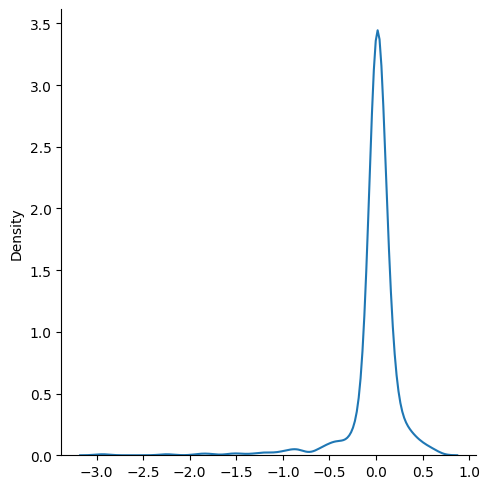

In [71]:
sns.displot(scores["score"], kind="kde")

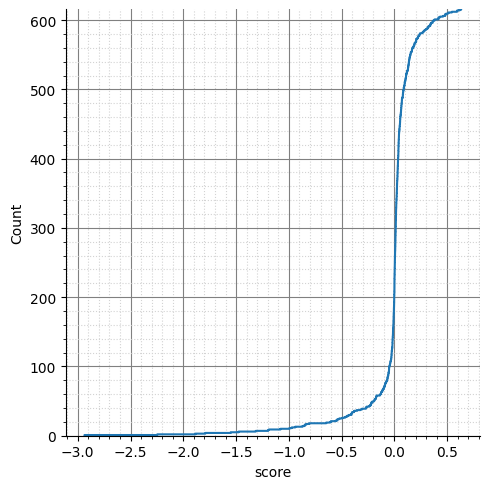

In [299]:
sns.displot(scores, x="score", kind="ecdf", stat="count")
src.utils.mygrid()
savefig("../reports/figures/score_distribution.pdf")

Okay, that is nearly normally distributed around 0, but with a long left tail in the negative values. So there they are: The particularly bad reflections I keep noticing!

# Automated tests for all presynth-metrics

In [126]:
def get_quantiles(column):
    return (
        scores.select(column).quantile(.05)[0,0], 
        scores.select(column).quantile(.95)[0,0],
    )

In [260]:
filter_arr = []
# smaller than threshold
filter_arr.extend([
    {
        "rule": lambda t, pre_metric=pre_metric: pl.col(pre_metric) < t, 
        "description_proto": f"{pre_metric} < $0",
        "params": np.linspace(*get_quantiles(pre_metric), num=1000),
    } for pre_metric in pre_metrics
])
filter_arr.extend([
    {
        "rule": lambda t, pre_metric=pre_metric: pl.col(pre_metric) > t, 
        "description_proto": f"{pre_metric} > $0",
        "params": np.linspace(*get_quantiles(pre_metric), num=1000),
    } for pre_metric in pre_metrics
])
filter_arr.extend([
    {
        "rule": lambda t, pre_metric=pre_metric: pl.col(pre_metric).abs() < t, 
        "description_proto": f"|{pre_metric}| < $0",
        "params": np.linspace(*get_quantiles(pl.col(pre_metric).abs()), num=1000),
    } for pre_metric in ["m1", "m1_hf"]
])
filter_arr.append(
    {
        "rule": lambda t: [
            pl.col("filter_energy") < t[0],
            pl.col("directivity_boost") < t[1]
        ], 
        "description_proto": f"filter_energy < $0 & directivity_boost < $1",
        "params": np.array([[
            (t,u) for t in np.linspace(*get_quantiles("filter_energy"), 100)
        ] for u in np.linspace(*get_quantiles("directivity_boost"), 100)]).reshape((-1, 2))
    }
)
for main_criterion in ["filter_energy", "directivity_boost"]:
    filter_arr.append(
        {
            "rule": lambda t, main_criterion=main_criterion: [
                pl.col(main_criterion) < t[0],
                pl.col("relative_imsrc_time").sub(.55).abs() < t[1]
            ], 
            "description_proto": f"{main_criterion} < $0 & |relative_imsrc_time - c(0.55)| < $1",
            "params": np.array([[
                (t,u) for t in np.linspace(*get_quantiles(main_criterion), 100)
            ] for u in np.linspace(*get_quantiles(pl.col("relative_imsrc_time").abs()), 100)]).reshape((-1, 2))
        }
    )
    filter_arr.append(
        {
            "rule": lambda t, main_criterion=main_criterion: [
                pl.col(main_criterion) < t[0],
                pl.col("m1") > t[1]
            ], 
            "description_proto": f"{main_criterion} < $0 & m1 > $1",
            "params": np.array([[
                (t,u) for t in np.linspace(*get_quantiles(main_criterion), 100)
            ] for u in np.linspace(*get_quantiles("m1"), 100)]).reshape((-1, 2))
        }
    )
    filter_arr.append(
        {
            "rule": lambda t, main_criterion=main_criterion: [
                pl.col(main_criterion) < t[0],
                pl.col("m1") < t[1]
            ], 
            "description_proto": f"{main_criterion} < $0 & m1 < $1",
            "params": np.array([[
                (t,u) for t in np.linspace(*get_quantiles(main_criterion), 100)
            ] for u in np.linspace(*get_quantiles("m1"), 100)]).reshape((-1, 2))
        }
    )
    filter_arr.append(
        {
            "rule": lambda t, main_criterion=main_criterion: [
                pl.col(main_criterion) < t[0],
                pl.col("m1").abs() < t[1]
            ], 
            "description_proto": f"{main_criterion} < $0 & |m1| < $1",
            "params": np.array([[
                (t,u) for t in np.linspace(*get_quantiles(main_criterion), 100)
            ] for u in np.linspace(*get_quantiles(pl.col("m1").abs()), 100)]).reshape((-1, 2))
        }
    )
    filter_arr.append(
        {
            "rule": lambda t, main_criterion=main_criterion: [
                pl.col(main_criterion) < t[0],
                pl.col("m2") < t[1]
            ], 
            "description_proto": f"{main_criterion} < $0 & m2 < $1",
            "params": np.array([[
                (t,u) for t in np.linspace(*get_quantiles(main_criterion), 100)
            ] for u in np.linspace(*get_quantiles("m2"), 100)]).reshape((-1, 2))
        }
    )
    filter_arr.append(
        {
            "rule": lambda t, main_criterion=main_criterion: [
                pl.col(main_criterion) < t[0],
                pl.col("m2_hf") < t[1]
            ], 
            "description_proto": f"{main_criterion} < $0 & m2_hf < $1",
            "params": np.array([[
                (t,u) for t in np.linspace(*get_quantiles(main_criterion), 100)
            ] for u in np.linspace(*get_quantiles("m2_hf"), 100)]).reshape((-1, 2))
        }
    )
filter_arr.append(
    {
        "rule": lambda t: [
            pl.col("peak_prominence") > t[0],
            pl.col("doa_stability_1deg") > t[1]
        ], 
        "description_proto": f"peak_prominence > $0 & doa_stability_1deg > $1",
        "params": np.array([[
            (t,u) for t in np.linspace(*get_quantiles("peak_prominence"), 100)
        ] for u in np.linspace(*get_quantiles("doa_stability_1deg"), 100)]).reshape((-1, 2))
    }
)
filter_arr.append(
    {
        "rule": lambda t: [
            pl.col("relative_imsrc_time").sub(t[0]).abs() < t[1],
        ], 
        "description_proto": f"|relative_imsrc_time - $0| < $1",
        "params": np.array([[
            (t,u) for t in np.linspace(0, 1, 100)
        ] for u in np.linspace(*get_quantiles(pl.col("relative_imsrc_time").abs()), 100)]).reshape((-1, 2))
    }
)
filter_arr.append(
    {
        "rule": lambda t: [
            pl.col("score") > t,
        ], 
        "description_proto": f"score > $0",
        "params": [0],
    }
)
filter_arr.append(
    {
        "rule": lambda t: [
            pl.col("filter_energy") < t,
        ], 
        "description_proto": f"filter_energy < c($0)",
        "params": [5.5],
    }
)
filter_arr.append(
    {
        "rule": lambda t: t,
        "description_proto": f"no filter",
        "params": [True],
    }
)
len(filter_arr)

58

In [321]:
pl.DataFrame(np.zeros((4,2)), ["a", "b"])

a,b
f64,f64
0.0,0.0
0.0,0.0
0.0,0.0
0.0,0.0


In [467]:
def evaluate_bootstrapped_array(*data_columns, original_df, filter_rule):
    df = pl.LazyFrame(data_columns, original_df.columns) # might be very slightly faster, I don't know...
    return df.filter(filter_rule).select("score").sum().collect()[0,0] / df.filter(pl.col("score") > 0).select("score").sum().collect()[0,0]

In [463]:
%timeit evaluate_bootstrapped_array(*df_here.to_numpy().T, original_df=df_here, filter_rule=pl.col("filter_energy") < 5.5)

999 µs ± 123 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [478]:
def evaluate_filter_rule(filter_rule, params, df=scores, do_plot=True):
    """filter_rule is a lambda taking one of params"""
    #print(filter_rule)
    #print(params)
    score_sums_for_params = np.array(
        [
            df.filter(
                 filter_rule(p)
            ).select("score").sum()[0,0] for p in params
        ]
    )
    #print(score_sums_for_params)
    if do_plot:
        plot(params, score_sums_for_params)
        mygrid()

    max_idx = np.argmax(score_sums_for_params)

    optimal_filter_rule = filter_rule(params[max_idx])
    optimal_filtered = df.filter(optimal_filter_rule)

    n_filtered = optimal_filtered.shape[0]
    n_unfiltered = df.shape[0]

    n_filtered_positive = optimal_filtered.filter(pl.col("score") > 0).shape[0]
    n_unfiltered_positive = df.filter(pl.col("score") > 0).shape[0]

    n_filtered_negative = optimal_filtered.filter(pl.col("score") < 0).shape[0]
    n_unfiltered_negative = df.filter(pl.col("score") < 0).shape[0]

    filtered_positive = np.float64(1 - n_filtered_positive/n_unfiltered_positive)
    filtered_negative = np.float64(1 - n_filtered_negative/n_unfiltered_negative)

    if optimal_filtered.shape[0] > 0:
        bootstrap_array = optimal_filtered.select("score").to_numpy().T
        #print(bootstrap_array.shape)
        r = scipy.stats.bootstrap(
            optimal_filtered.select("score").to_numpy().T,
            np.sum
        )
        # second kind of booststrap
        # bootstrap whole data, then filter each bootstrapped sample, calculate sum relative to bootstrapped sample
        # df_here = scores.select(pl.exclude("room", "from_listener")) # remove string columns
        # r2 = scipy.stats.bootstrap(
        #     df_here.to_numpy().T,
        #     functools.partial(evaluate_bootstrapped_array, original_df=df_here, filter_rule=optimal_filter_rule),
        #     paired=True,
        #     vectorized=False,
        # )
        # validated to have same results
    else:
        r = Mock(
            confidence_interval=Mock(
                low=-np.inf,
                high=+np.inf,
            )
        )
        # r2 = Mock(
        #     confidence_interval=Mock(
        #         low=-np.inf,
        #         high=+np.inf,
        #     )
        # )

    return {
        "optimal_param": params[max_idx],
        "max_score": score_sums_for_params[max_idx],
        "max_score_low": r.confidence_interval.low,
        "max_score_high": r.confidence_interval.high,
        # "max_score_low2": r2.confidence_interval.low,
        # "max_score_high2": r2.confidence_interval.high,
        "filtered": 1 - n_filtered/n_unfiltered,
        "filtered_positive": filtered_positive,
        "filtered_negative": filtered_negative,
        "negative_ratio": filtered_negative/filtered_positive,
    }

In [472]:
filter_results = [
    evaluate_filter_rule(d["rule"], d["params"], do_plot=False) for d in filter_arr
]

C:\Users\jcmfs\Documents\MA\e4-vis-dataset\.venv\Lib\site-packages\scipy\stats\_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\jcmfs\AppData\Local\Temp\ipykernel_9092\3946506242.py:44: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  r2 = scipy.stats.bootstrap(
C:\Users\jcmfs\AppData\Local\Temp\ipykernel_9092\3946506242.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  "negative_ratio": filtered_negative/filtered_positive,
C:\Users\jcmfs\AppData\Local\Temp\ipykernel_9092\3946506242.py:74: RuntimeWarning: invalid value encountered in scalar divide
  "negative_ratio": filtered_negative/filtered_positive,


[{'optimal_param': 1508.3123123123123,
  'max_score': 3.5345753843327214,
  'max_score_low': -5.270580706762989,
  'max_score_high': 9.670492835672958,
  'max_score_low2': -0.16103552469126584,
  'max_score_high2': 0.2721631377705371,
  'filtered': 0.6964285714285714,
  'filtered_positive': 0.6683417085427136,
  'filtered_negative': 0.7477064220183487,
  'negative_ratio': 1.1187487066289579},
 {'optimal_param': 43.0,
  'max_score': 0.0,
  'max_score_low': -inf,
  'max_score_high': inf,
  'max_score_low2': -inf,
  'max_score_high2': inf,
  'filtered': 1.0,
  'filtered_positive': 1.0,
  'filtered_negative': 1.0,
  'negative_ratio': 1.0},
 {'optimal_param': 0.021108505262768962,
  'max_score': 1.3935916771711847,
  'max_score_low': -1.6708202049686067,
  'max_score_high': 4.191475276559031,
  'max_score_low2': -0.05388399225295606,
  'max_score_high2': 0.11749442250643582,
  'filtered': 0.8327922077922079,
  'filtered_positive': 0.8291457286432161,
  'filtered_negative': 0.839449541284403

In [475]:
description_arr = []
def format_significant(x, sig_digits=3):
    if x == 0:
        return "0"
    elif abs(x) >= 10**(sig_digits - 1):
        return f"{int(round(x, 0))}"
    else:
        return f"{x:.{sig_digits}g}"

for i in range(len(filter_arr)):
    description_proto = filter_arr[i]["description_proto"]
    optimal_param = np.atleast_1d(np.array(filter_results[i]["optimal_param"]))

    expr = description_proto
    values = optimal_param
    for i, v in enumerate(values):
        expr = expr.replace(f"${i}", format_significant(v))
    description_arr.append(
        expr
    )
description_arr

['start < 1508',
 'length < 43',
 'm0 < 0.0211',
 'm1 < 18.2',
 'm2 < 4.27',
 'imsrc_sample < 1636',
 'doa_std < 5.65',
 'doa_nn < 0.265',
 'distance_boost < 20.7',
 'order < 2',
 'm0_hf < 0.0126',
 'm1_hf < 19.2',
 'm2_hf < 4.22',
 'peak_prominence < 0.582',
 'doa_stability_1deg < 0',
 'doa_stability_5deg < 0',
 'relative_imsrc_time < 0.928',
 'directivity_boost < 16.5',
 'filter_energy < 6.03',
 'start > 2567',
 'length > 60',
 'm0 > 0.0613',
 'm1 > -30.2',
 'm2 > 6.76',
 'imsrc_sample > 2516',
 'doa_std > 10.3',
 'doa_nn > 0.65',
 'distance_boost > 25.2',
 'order > 5',
 'm0_hf > 0.0603',
 'm1_hf > -30',
 'm2_hf > 6.9',
 'peak_prominence > 9.25',
 'doa_stability_1deg > 10',
 'doa_stability_5deg > 29',
 'relative_imsrc_time > 0.177',
 'directivity_boost > 29.9',
 'filter_energy > -11.4',
 '|m1| < 27.1',
 '|m1_hf| < 24.1',
 'filter_energy < 5.56 & directivity_boost < 29.4',
 'filter_energy < 5.56 & |relative_imsrc_time - c(0.55)| < 2.85',
 'filter_energy < 5.56 & m1 > -145',
 'filter_e

In [476]:
filter_df = pl.DataFrame(
    [{k: v for k, v in d.items() if k != "optimal_param"} for d in filter_results]
).with_columns(
    description = np.array(description_arr)
).sort("max_score", descending=True).select(
    "description",
    "max_score",
    "max_score_low",
    "max_score_high",
    "max_score_low2",
    "max_score_high2",
    "filtered",
    filtered_god_to_bad = pl.col("filtered_positive") / pl.col("filtered_negative")
).rename(
    dict(max_score = "score_sum", max_score_low = "score_sum_low", max_score_high = "score_sum_high"),
)
with pl.Config(set_fmt_str_lengths = 100, set_tbl_rows=100):
    display(filter_df)

description,score_sum,score_sum_low,score_sum_high,max_score_low2,max_score_high2,filtered,filtered_god_to_bad
str,f64,f64,f64,f64,f64,f64,f64
"""score > 0""",34.021587,29.88966,39.146603,NaN,NaN,0.353896,0.0
"""filter_energy < 5.56 & m1 < 26.3""",24.806036,19.332529,30.189508,0.587367,0.800806,0.357143,0.331842
"""filter_energy < 5.56 & |relative_imsrc_time - c(0.55)| < 2.85""",24.053176,16.777783,30.055458,0.486043,0.808046,0.301948,0.267296
"""filter_energy < 6.03""",23.960921,16.419201,30.004336,0.47863,0.80506,0.189935,0.156497
"""filter_energy < 5.56 & |m1| < 183""",23.948634,16.506244,29.803479,0.467451,0.802181,0.266234,0.240236
"""filter_energy < c(5.5)""",23.871343,16.268575,29.783922,0.478127,0.801324,0.202922,0.17297
"""filter_energy < 5.56 & directivity_boost < 29.4""",23.769114,16.012629,29.668056,0.465179,0.800446,0.220779,0.20471
"""filter_energy < 5.56 & m1 > -145""",23.718294,16.25211,29.60855,0.464516,0.797702,0.24513,0.239962
"""directivity_boost < 16.5""",22.928444,17.532411,27.964766,0.530536,0.754545,0.280844,0.313705


In [477]:
significant = filter_df.with_columns(
    pl.col("score_sum") / pl.col("score_sum").max(),
    pl.col("score_sum_high") / pl.col("score_sum").max(),
    pl.col("score_sum_low") / pl.col("score_sum").max(),
).filter(
    (
        pl.col("score_sum_low") >= pl.col("score_sum_high").filter(pl.col("description") == "no filter")
    ) | (
        pl.col("description").is_in(["no filter"]) # inclusion list even though non-significant
    )
)
with pl.Config(set_fmt_str_lengths = 100, set_tbl_rows=100):
    display(significant)

description,score_sum,score_sum_low,score_sum_high,max_score_low2,max_score_high2,filtered,filtered_god_to_bad
str,f64,f64,f64,f64,f64,f64,f64
"""score > 0""",1.0,0.87855,1.15064,NaN,NaN,0.353896,0.0
"""filter_energy < 5.56 & m1 < 26.3""",0.729126,0.568243,0.887363,0.587367,0.800806,0.357143,0.331842
"""filter_energy < 5.56 & |relative_imsrc_time - c(0.55)| < 2.85""",0.706997,0.493151,0.883423,0.486043,0.808046,0.301948,0.267296
"""filter_energy < 6.03""",0.704286,0.482611,0.881921,0.47863,0.80506,0.189935,0.156497
"""filter_energy < 5.56 & |m1| < 183""",0.703925,0.48517,0.876017,0.467451,0.802181,0.266234,0.240236
"""filter_energy < c(5.5)""",0.701653,0.478184,0.875442,0.478127,0.801324,0.202922,0.17297
"""filter_energy < 5.56 & directivity_boost < 29.4""",0.698648,0.470661,0.872036,0.465179,0.800446,0.220779,0.20471
"""filter_energy < 5.56 & m1 > -145""",0.697154,0.4777,0.870287,0.464516,0.797702,0.24513,0.239962
"""directivity_boost < 16.5""",0.673938,0.515332,0.821971,0.530536,0.754545,0.280844,0.313705
